In [1]:
import os
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

import missingno as msno

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score  
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix, accuracy_score 

import numpy as np
import matplotlib.pyplot as plt
import sage 

/home/jlm217/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.chdir('/home/jlm217/rds/rds-mrc-bsu-csoP2nj6Y6Y/mimah/stopah/stopah/data') 

pd.set_option('display.max_columns', None)  

ro.r['load']('STOPAH_ForSolon.RData')

def R_dataset(x):
    with (ro.default_converter + pandas2ri.converter).context():
        stopah = ro.conversion.get_conversion().rpy2py(ro.r[x])
    return stopah

stopah = R_dataset('stopah')

R[write to console]: Warning:
R[write to console]:  namespace ‘pROC’ is not available and has been replaced
by .GlobalEnv when processing object ‘roc.objs’



In [3]:
selected = ['D28_DTH','D90_DTH','Prednisolone']

baseline = ['Gender','Baseline_sepsis','Baseline_GIB',
'Age.at.randomisation..calc.','Weight','Max.grams.of.alcohol.drunk.per.day..calc.','Hepatic.Encephalopathy...Merged',
'Temperature...Merged','Pulse...Merged','Systolic.BP...Merged','Diastolic.BP...Merged','MAP','Hb...Merged','Platelets...Merged',
'WBC...Merged','Neutrophils...Merged','INR...Merged.clinical.and.calc','Bilirubin.Merged','ALT...Merged','ALP...Merged',
'Albumin...Merged','Sodium...Merged','Potassium...Merged','Urea...Merged','Creatinine...Merged','NLR_0','bDNA',
'Ferritin_ngml','Iron_mumoll','Transferrin','TSAT','PNPLA3_Add','PNPLA3_Rec','HPCT_NG'] 

sevenday = ['Hepatic.Encephalopathy...Treatment.Day.7..',
'Day.7.infection',
'Gastrointestinal.Bleed.since.the.last.visit.Gastrointestinal.bleed...and.Choose..Treatment.Day.7..',
'Temperature..Treatment.Day.7..',
'Pulse..Treatment.Day.7..',
'Systolic.BP..Treatment.Day.7..',
'Diastolic.BP..Treatment.Day.7..',
'MAP..Treatment.Day.7',
'Hb..1.decimal.point..Haematology..Treatment.Day.7..',
'Platelets.day.7',
'WBC.day.7',
'Neutrophils.day.7',
'INR.clinical.and.calc.day.7',
'Bilirubin.day.7',
'ALT.day.7',
'ALP.day.7',
'Albumin.day.7',
'Sodium.day.7',
'Potassium.day.7',
'Urea.day.7',
'Creatinine.day.7']

#reduce data set to target, treatment and therapy

stopah = stopah[sevenday+['Prednisolone','D28_DTH']]

stopah.reset_index(drop=True, inplace=True)

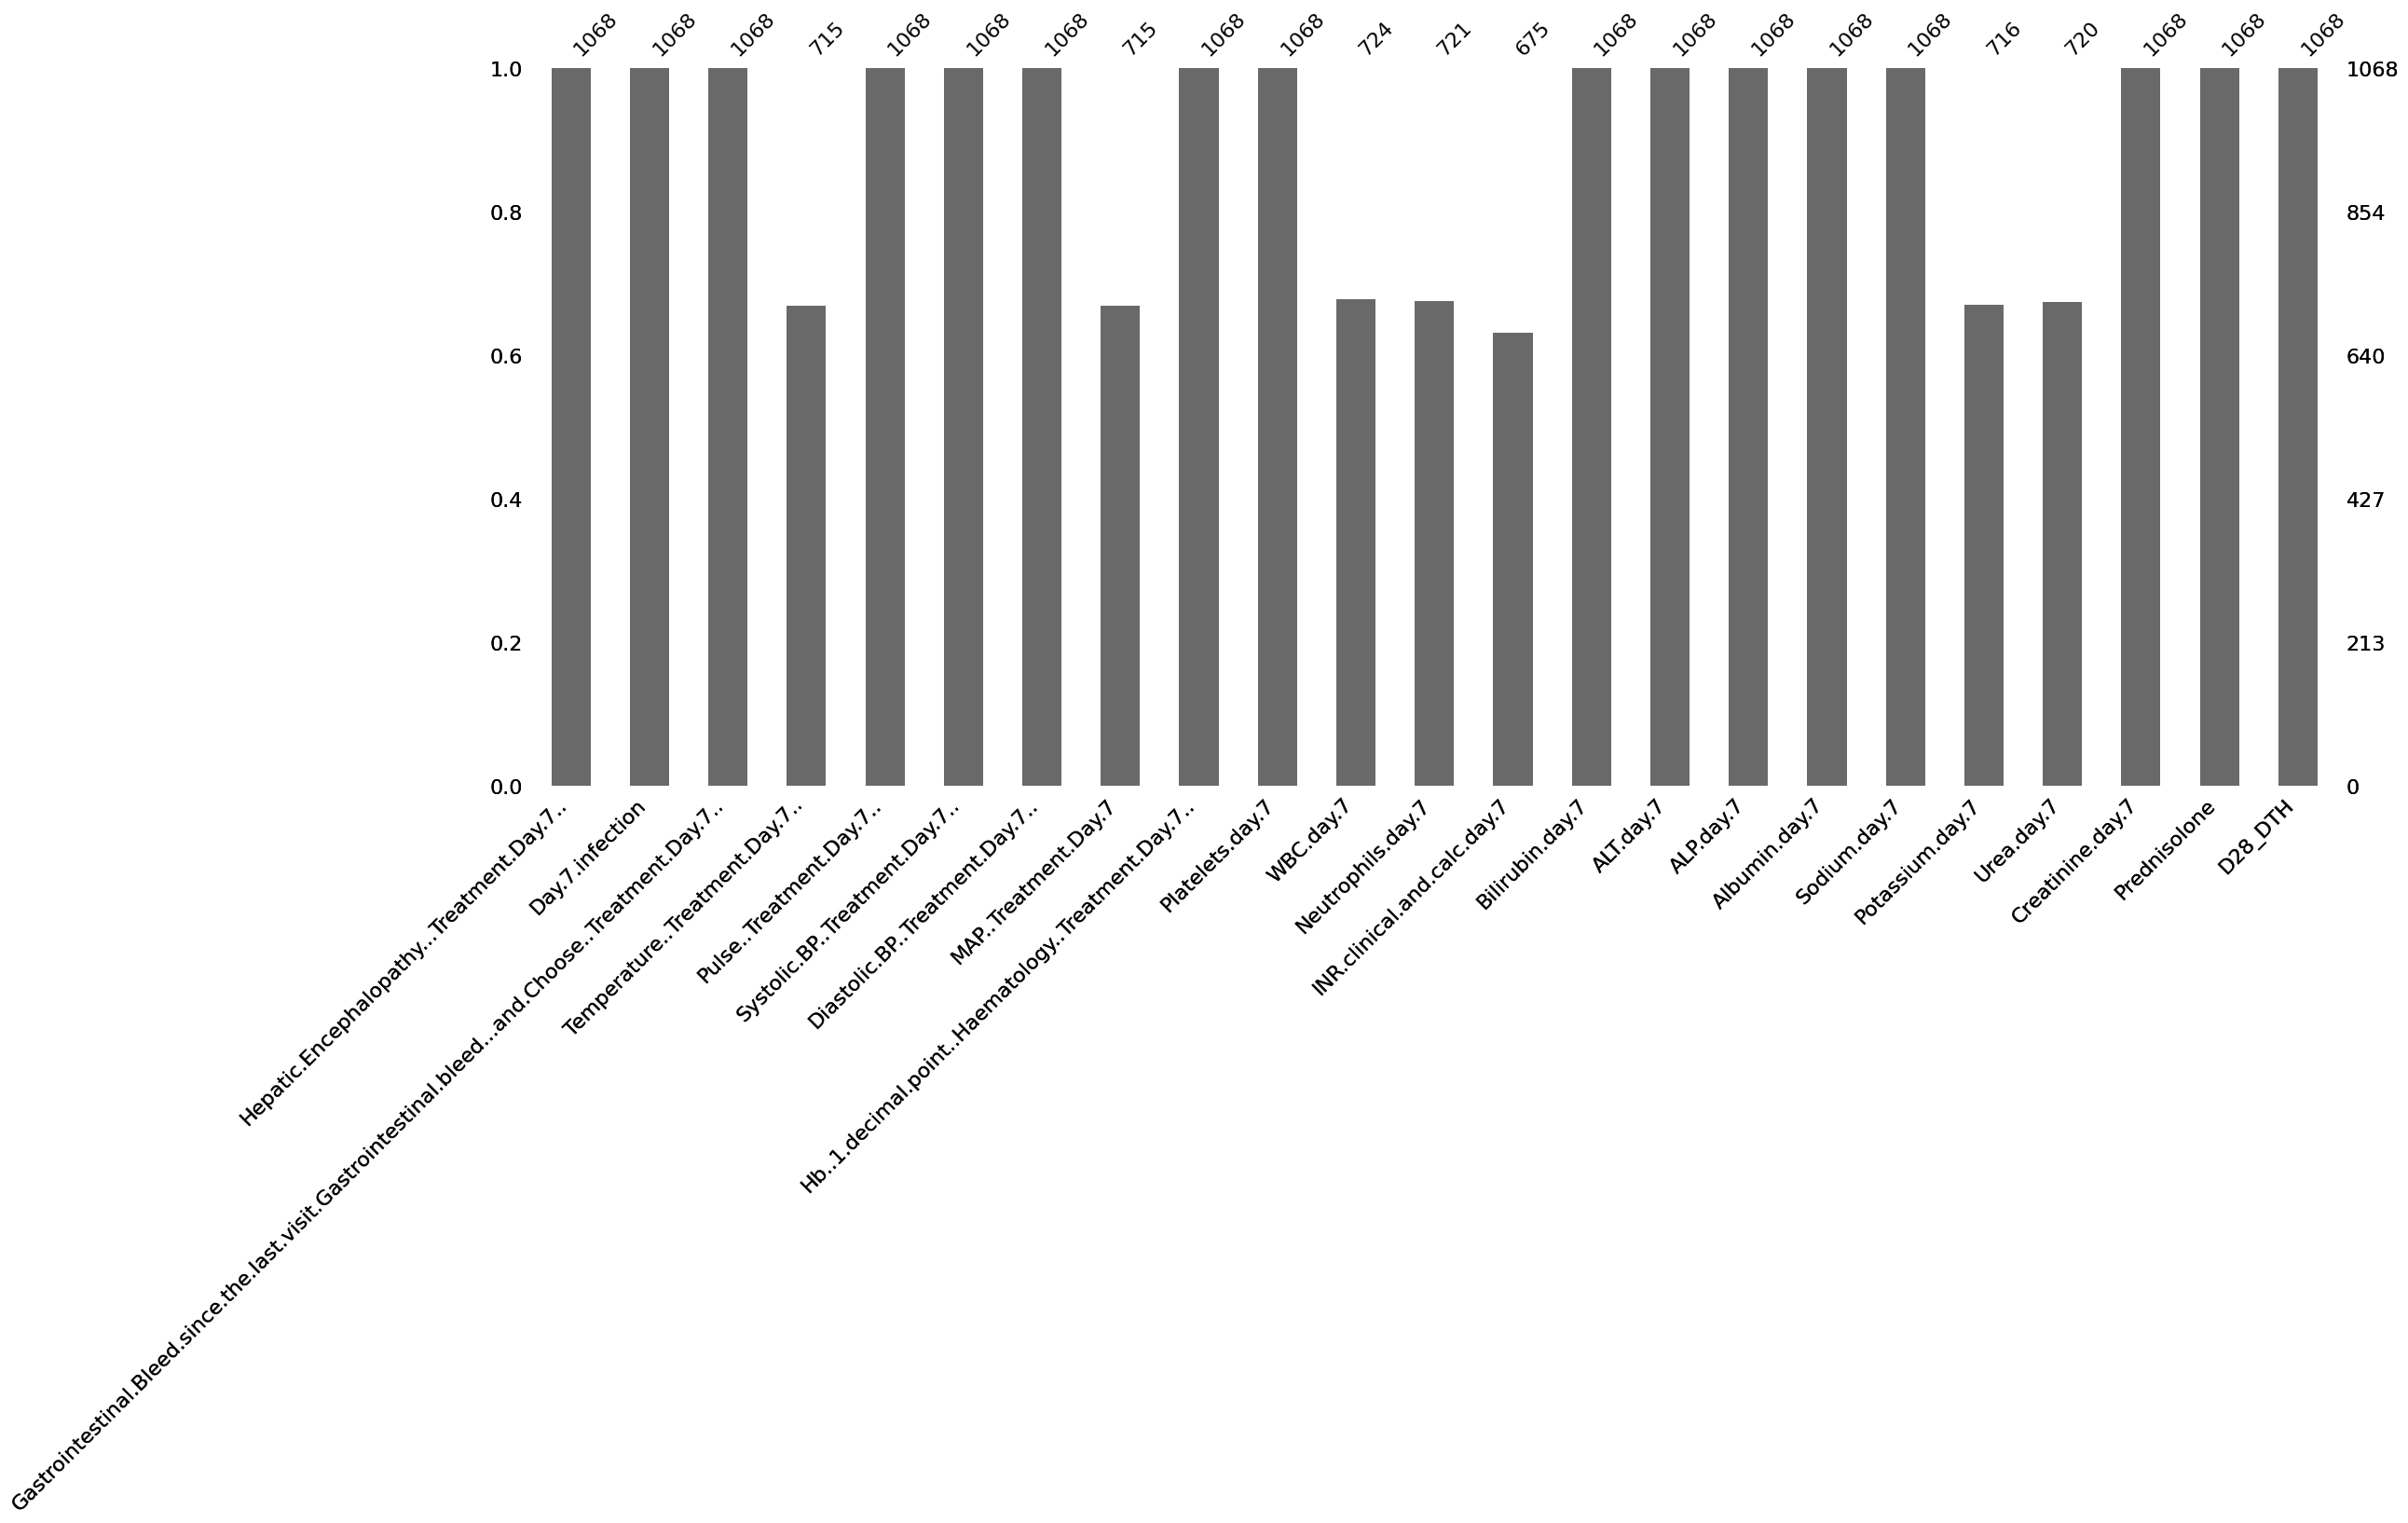

In [4]:
## Missing data situation

%matplotlib inline
msno.bar(stopah)
fig = msno.bar(stopah)
fig_copy = fig.get_figure()

In [5]:
stopah = stopah.dropna()

In [6]:
#Split into train-test based on treatment 

train = stopah.loc[stopah['Prednisolone']==0].drop(['Prednisolone'], axis=1)

test= stopah.loc[stopah['Prednisolone']==1].drop(['Prednisolone'], axis=1)

train.reset_index(drop=True)
test.reset_index(drop=True)

,Hepatic.Encephalopathy...Treatment.Day.7..,Day.7.infection,Gastrointestinal.Bleed.since.the.last.visit.Gastrointestinal.bleed...and.Choose..Treatment.Day.7..,Temperature..Treatment.Day.7..,Pulse..Treatment.Day.7..,Systolic.BP..Treatment.Day.7..,Diastolic.BP..Treatment.Day.7..,MAP..Treatment.Day.7,Hb..1.decimal.point..Haematology..Treatment.Day.7..,Platelets.day.7,WBC.day.7,Neutrophils.day.7,INR.clinical.and.calc.day.7,Bilirubin.day.7,ALT.day.7,ALP.day.7,Albumin.day.7,Sodium.day.7,Potassium.day.7,Urea.day.7,Creatinine.day.7,D28_DTH
0,1,0,0,36.1,75,110,72,84.666667,122,107,23.0,21.4,1.0,24,195,326,16,135,3.8,8.7,54,0
1,0,0,0,36.3,78,108,63,78.000000,139,129,10.3,7.7,2.2,530,87,98,20,133,3.4,6.4,85,0
2,0,0,0,36.5,82,110,60,76.666667,87,59,10.2,9.1,1.4,185,81,100,28,139,3.2,7.1,130,0
3,1,0,1,37.6,61,129,80,96.333333,94,297,10.4,9.4,1.0,583,267,271,40,138,3.6,7.6,103,0
4,0,0,0,36.8,72,130,90,103.333333,117,249,12.4,9.3,1.2,319,68,226,32,136,3.8,3.5,53,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,0,0,0,37.0,109,140,80,100.000000,117,242,24.1,20.7,1.1,221,112,265,25,135,3.5,7.0,61,0
293,0,0,0,36.8,61,98,45,62.666667,92,146,7.9,4.6,1.8,84,30,68,30,134,4.3,2.9,61,0
294,0,1,0,37.8,85,120,70,86.666667,120,324,20.9,17.0,1.5,393,38,333,28,142,3.2,2.8,37,0
295,0,0,0,36.1,80,109,75,86.333333,114,156,14.2,11.9,1.6,58,29,99,28,136,4.2,6.0,54,0


In [7]:
X_train = train.drop(['D28_DTH'],axis=1)
y_train = train['D28_DTH']

X_test = test.drop(['D28_DTH'],axis=1)
y_test = test['D28_DTH']


In [8]:
#Balance weights
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train #provide your own target name
)


rf = RandomForestClassifier(n_estimators=15,max_depth=8,random_state=24,criterion='gini',min_samples_split=10)

In [9]:
model = rf.fit(X_train, y_train)

In [10]:
pred_prob = rf.predict_proba(X_test)

auc_score = roc_auc_score(y_test, pred_prob[:,1])

print('Training accuracy: ', np.mean(rf.predict(X_train) ==y_train)*100) 
print ('Test accuracy:', np.mean(rf.predict(X_test) ==y_test)*100)
print('AUC Score:',(auc_score)*100)

Training accuracy:  93.56725146198829
Test accuracy: 84.17508417508418
AUC Score: 79.81135670731707


In [11]:
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1], pos_label=1)

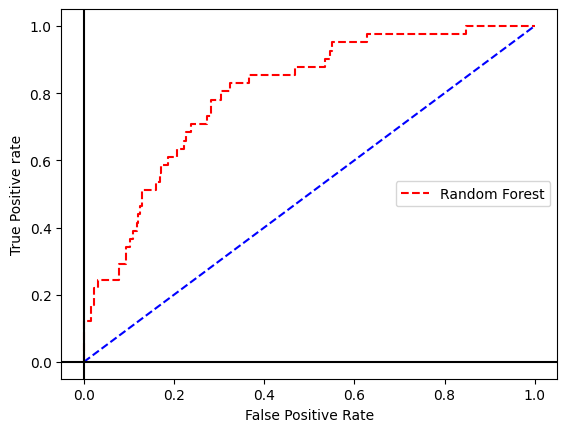

In [12]:
plt.axes(facecolor='white')
# plot roc curves

plt.plot(fpr, tpr, linestyle='--',color='red',label='Random Forest') #label='Random Forest'
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

#plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')
plt.grid(False)

plt.axhline(0, color='black')
plt.axvline(0, color='black')

#ax = fig.add_axes([1,1,0,0])

#ax.set_facecolor("white")

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();



In [13]:
from sklearn.inspection import permutation_importance

In [14]:
rf.feature_importances_

array([0.02839896, 0.00394783, 0.00868316, 0.03626741, 0.0302996 ,
       0.05102318, 0.03354899, 0.04149791, 0.06315814, 0.04686993,
       0.01946338, 0.09858313, 0.03600316, 0.09919836, 0.01899788,
       0.03510991, 0.05681399, 0.02058101, 0.02504557, 0.16957025,
       0.07693825])

In [15]:
features = stopah.columns

Text(0, 0.5, 'variable')

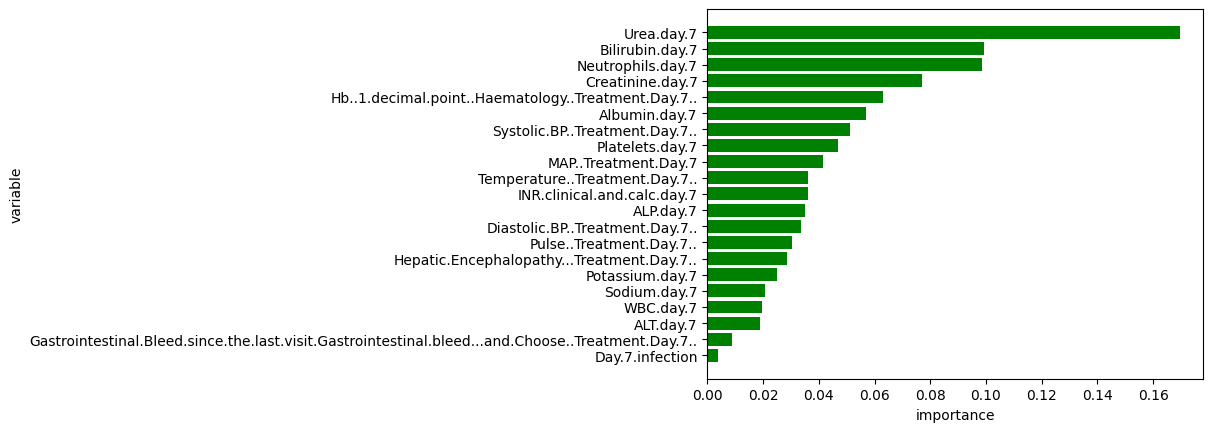

In [16]:
importances = rf.feature_importances_
indices = np.argsort(importances)

values = list(rf.feature_importances_[indices])

#values = [ '%.2f' % elem for elem in values ]

names = [features[i] for i in indices]

importance = pd.DataFrame({'variable' : names, 'importance': values})

importance = importance.sort_values('importance')

plt.axes(facecolor='white')
plt.barh(importance.variable,importance.importance,color='green')
plt.grid(False)
plt.xlabel('importance')
plt.ylabel('variable')

In [17]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
perm_importances = result.importances_mean
perm_imp = pd.DataFrame({'variable' : stopah[X_train.columns].columns, 'importance': perm_importances}).sort_values('importance')

round(perm_imp,2)

,variable,importance
11,Neutrophils.day.7,-0.02
5,Systolic.BP..Treatment.Day.7..,-0.01
19,Urea.day.7,-0.01
7,MAP..Treatment.Day.7,-0.01
13,Bilirubin.day.7,-0.01
16,Albumin.day.7,-0.00
14,ALT.day.7,-0.00
17,Sodium.day.7,-0.00
18,Potassium.day.7,-0.00
3,Temperature..Treatment.Day.7..,-0.00


Text(0, 0.5, 'variable')

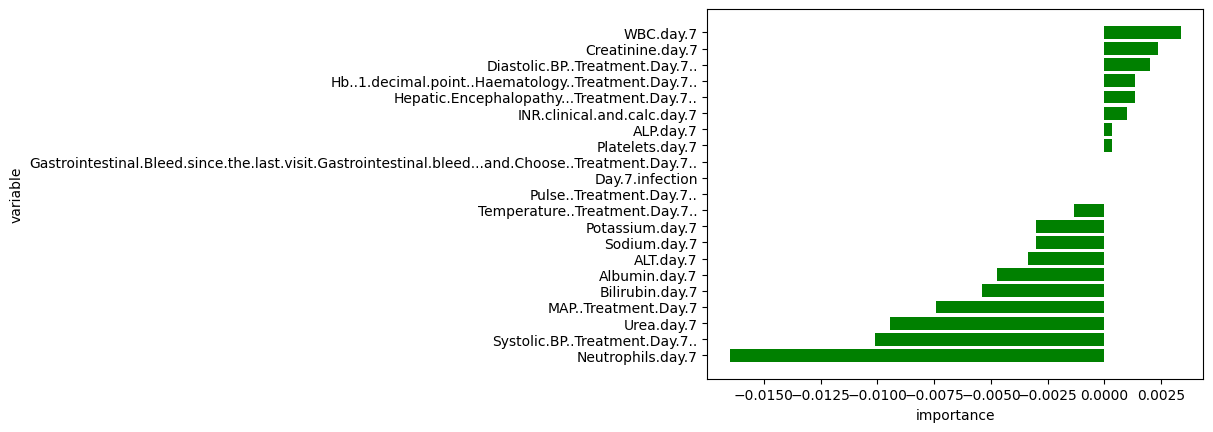

In [18]:
plt.axes(facecolor='white')
plt.barh(perm_imp.variable,perm_imp.importance,color='green')
plt.grid(False)
plt.xlabel('importance')
plt.ylabel('variable')

In [19]:
# Setup and calculate
imputer = sage.MarginalImputer(model, train[:300])
estimator = sage.KernelEstimator(imputer, 'cross entropy')


In [20]:
estimator

In [21]:
df=stopah

In [22]:
# Split data, with total count serving as regression target
train, test = train_test_split(
    df.values, test_size=int(0.25 * len(df.values)), random_state=123)
train, val = train_test_split(
    train, test_size=int(0.25 * len(df.values)), random_state=123)
Y_train = train[:, -1].copy()
Y_val = val[:, -1].copy()
Y_test = test[:, -1].copy()
train = train[:, :-3].copy()
val = val[:, :-3].copy()
test = test[:, :-3].copy()

In [23]:
model = rf.fit(train, Y_train)

In [24]:
# Setup and calculate
imputer = sage.MarginalImputer(model, train[:512])
estimator = sage.KernelEstimator(imputer, 'cross entropy')
sage_train = estimator(train, Y_train, thresh=0.025)
sage_val = estimator(val, Y_val, thresh=0.025)
sage_test = estimator(test, Y_test, thresh=0.025)

100%|██████████| 1/1 [02:04<00:00, 124.07s/it]     


In [25]:
feature_names = stopah.columns.tolist()[:-2]

/home/jlm217/.local/lib/python3.11/site-packages/sage/plotting.py:316: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


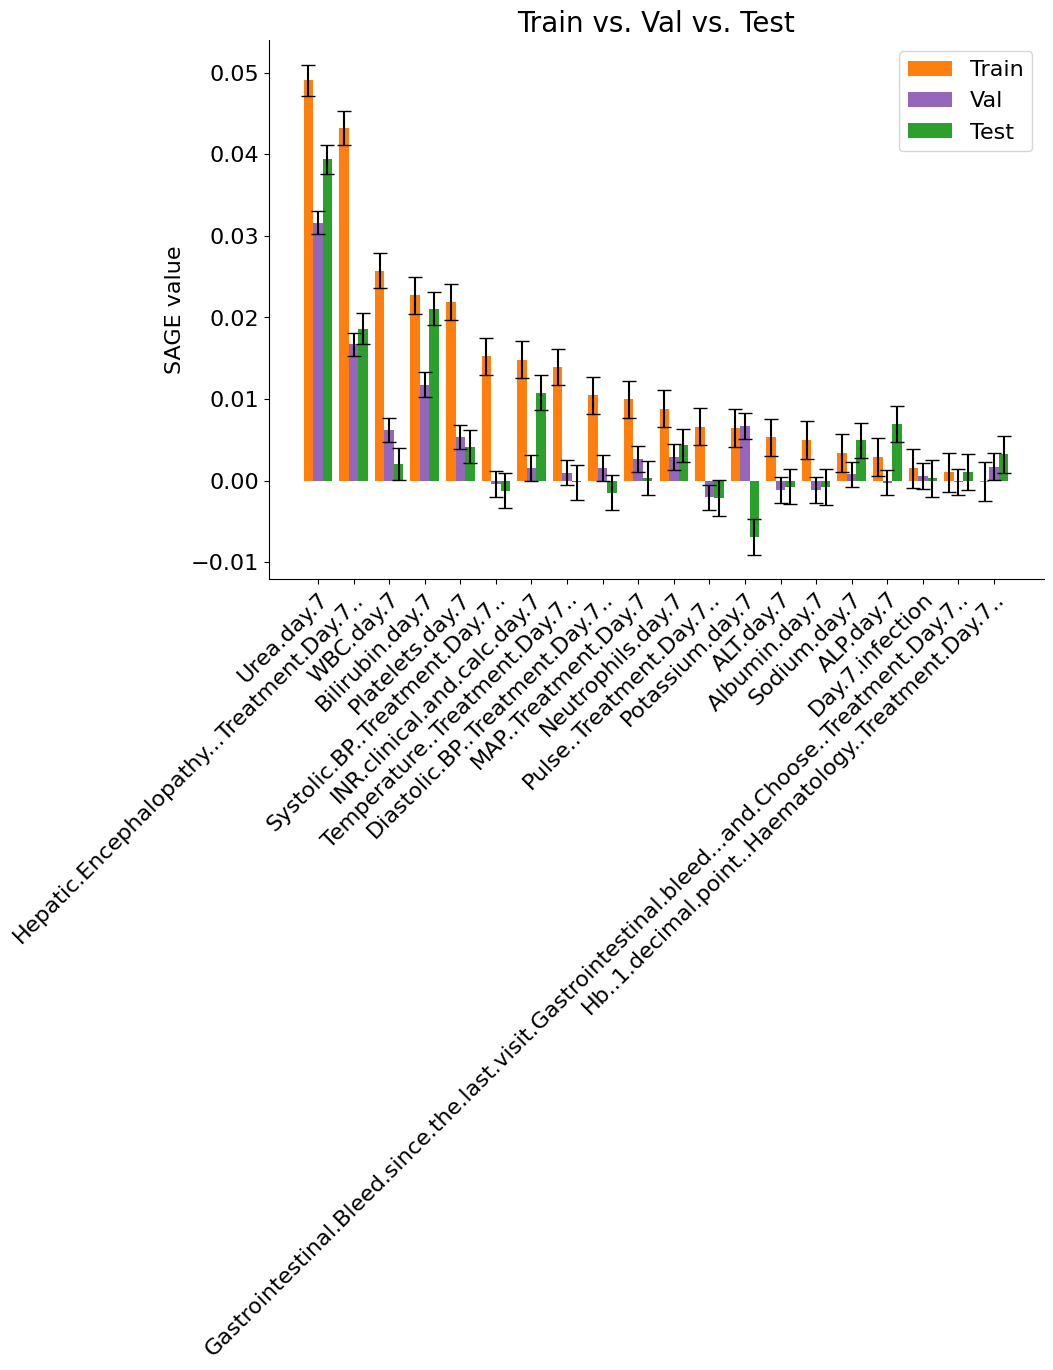

In [26]:
sage.comparison_plot((sage_train, sage_val, sage_test),
                     ('Train', 'Val', 'Test'),
                     feature_names,
                     colors=('tab:orange', 'tab:purple', 'tab:green'),
                     title='Train vs. Val vs. Test')
